This notebook will analyse the amplifier X speaker combinations I tested on 2021-05-28 afternoon. 

There are 2 amplifiers :

    * SNWG Siemers E401 (ref. to as just amp401 here)
    * SNWG Siemers E505 (ref. to as just amp505 here)

There are 3 Polaroid speakers :

    * SNWG Siemers E400 (sp400)
    * SNWG Siemers E504 (sp504) 
    * SNWG Siemers E550 (sp550)

*Side note: all experiments till now with fluctuating playback levels were with amp505Xsp504*

All 6 possible amplifierXspeaker combinations were tested. he calibration playback was played 10 times with 2 minute intervals for each ampxspeaker combination. 

*Side note: there was one point where the speaker didn't output any signal for amp505xsp504 and this was sorted out after a few ON/OFF's of the speaker + mic power. I wonder if this is of relevance, ie. a loose contact somewhere?*


In [1]:
import datetime as dt
import glob
import os
import matplotlib.pyplot as plt 
from matplotlib.gridspec import GridSpec
import numpy as np 
import pandas as pd
import soundfile as sf
import scipy.signal as signal 
import tqdm
from playback_code import playback_analysis as pa
from fullscale_calculations import *

In [2]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-05-28 17:40:17.351994


In [3]:
%matplotlib notebook

In [4]:
fs = 192000

In [5]:
def get_loudest_part(X, fs=192000, winsize=0.025):
    x_sq = np.sqrt(np.abs(X)**2)
    winsamples = int(fs*winsize)
    running_mean = np.convolve(x_sq, np.ones(winsamples)/winsamples, mode='same')
    threshold = np.percentile(running_mean, [10,90])
    indices = np.logical_and(running_mean >=threshold[0], running_mean>=threshold[1])
    return indices, running_mean

def extract_time_and_ttmt(fname):    
    parts = os.path.split(fname)[-1].split('_')
    return parts[0]+'_'+parts[-1]

def make_avged_fft(recording_name, fft_dictionary):
    # first check all ffts are the same size 
    fft_sizes = [len(fft_dictionary[recording_name][i][:,1]) for i in range(5)]
    if not np.all(np.array(fft_sizes)==fft_sizes[0]):
        raise ValueError(f'all FFTs not same size: {fft_sizes}')
    all_ffts = np.array([fft_dictionary[recording_name][i][:,1] for i in range(5)]).reshape(5,-1)
    avg_fft = 20*np.log10(np.mean(10**(all_ffts/20.0), axis=0))
    freqs = fft_dictionary[recording_name][0][:,0]
    return avg_fft, freqs


b,a = signal.butter(2, np.array([9000,95500])/(fs*0.5), 'bandpass')

In [6]:
combis = ['amp401_speaker504','amp401_speaker550','amp401_speaker400',
          'amp505_speaker504', 'amp505_speaker550', 'amp505_speaker400']

In [7]:
sweep_level_variation = {}

for combination in combis:
    on_axis_gras = glob.glob('2021-05-27/*'+combination+ '*.wav')
    unique_onaxis  = [extract_time_and_ttmt(each) for each in on_axis_gras]
    # get the sweep spectra 
    onaxis_gras_sweep_ffts = {}
    for identifier, filename in tqdm.tqdm(zip(unique_onaxis, on_axis_gras)):
        audio, fs = sf.read(filename)
        sweeps = np.array_split(audio[int(fs*0.5):int(fs*1.5)],5)

        sweep_ffts = {}

        for i,each in enumerate(sweeps):
            sweeps_bp = signal.lfilter(b,a,each)
            sweepregion, _ = get_loudest_part(sweeps_bp)
            sweep_only = sweeps_bp[sweepregion]
            sweeps_fft = 20*np.log10(np.abs(np.fft.rfft(sweep_only)))
            sweeps_freq = np.fft.rfftfreq(sweep_only.size,1.0/fs)
            sweep_ffts[i] = np.column_stack((sweeps_freq, sweeps_fft))
            onaxis_gras_sweep_ffts[identifier] = sweep_ffts
    recordings = list(onaxis_gras_sweep_ffts.keys())
    
    # make 'average' sweep spectrum
    all_avg_ffts = []
    for i in range(10):
        avgd_fft, freqs = make_avged_fft(recordings[i], onaxis_gras_sweep_ffts)
        all_avg_ffts.append(avgd_fft)

    # compare to first playback
    norm_first_pbk = np.column_stack((all_avg_ffts[0]-all_avg_ffts[i] for i in range(1,len(all_avg_ffts))) )
    sweep_level_variation[combination] = norm_first_pbk


10it [00:03,  3.02it/s]
<ipython-input-7-d0bed5fe2ed1>:31: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  norm_first_pbk = np.column_stack((all_avg_ffts[0]-all_avg_ffts[i] for i in range(1,len(all_avg_ffts))) )
10it [00:03,  2.77it/s]
10it [00:03,  3.15it/s]
10it [00:02,  3.56it/s]
10it [00:02,  3.61it/s]
10it [00:02,  3.69it/s]


<IPython.core.display.Javascript object>


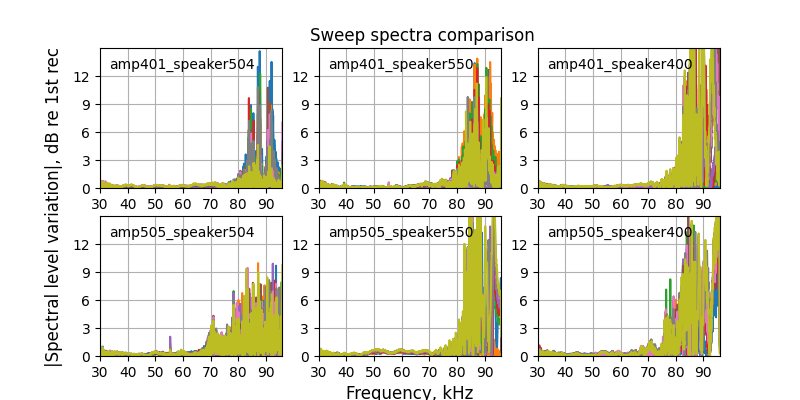

Text(-0.05, 1.05, 'Sweep spectra comparison')

In [8]:
plt.figure(figsize=(8,4))

for i, (combination, spectral_variation) in enumerate(sweep_level_variation.items()):
    plt.subplot(230+1+i)
    plt.text(0.05,0.85,combination, transform=plt.gca().transAxes, fontsize=10)
    for i in range(spectral_variation.shape[1]):
        plt.plot(freqs, np.abs(spectral_variation[:,i]))
    plt.ylim(0,15);plt.yticks(np.arange(0,15,3));plt.grid()
    plt.xlim(30000,96000);plt.xticks(np.arange(30000,96000,10000),np.arange(30,96,10))

plt.subplot(235);plt.xlabel('Frequency, kHz', fontsize=12)
plt.text(-0.3, -1.25, '|Spectral level variation|, dB re 1st rec',transform=plt.subplot(231).transAxes, fontsize=12,
        rotation=90)

plt.text(-0.05, 1.05, 'Sweep spectra comparison',transform=plt.subplot(232).transAxes, fontsize=12)

### Ampifier E505 is prone to add its own noise - Amplifier E401 is a better choice.
* As we can see, Amp401 provides much more consistent playbacks than Amp505. 
* Among the speakers, there is a consistent response across 30-80 kHz, but which one is better needs to be checked in more detail. 
* The combination that had been used till now: amp505 X speaker504 is indeed the noisiest of the combinations tested -- which explains the variation observed in the past. 


In [9]:
fireface_dbu_FS = 27
gras_dbVrmsPa = -49.17
gras_gain = 70
gras_datasheet_freqs = np.arange(20,90,5)*10**3

In [10]:
def calculate_tones_rec_level(audio, fs, tone_freqs, FS_dbu, gain, sensitivity_dbvrms, freq_bw=500):
    '''
    '''
    
    audio_parts = np.array_split(audio, len(tone_freqs))
    
    tones_rms = []
    for peak_freq, tone_part in zip(tone_freqs, audio_parts):
        loudest_inds, _ = get_loudest_part(tone_part, fs=fs)
        audio_part = tone_part[loudest_inds]
        signal_fft = np.fft.fft(audio_part)
        fftfreqs = np.fft.fftfreq(audio_part.size, 1/fs)
        if np.logical_or(peak_freq<=0, peak_freq>=fs*0.5):
            raise ValueError(f'A peakfrequency <0 or > Nyquist frequency ({peak_freq}Hz) has been detected. Aborting....')
        signal_band = np.array([peak_freq-freq_bw, peak_freq+freq_bw])
        signal_band[signal_band<0] = 0
        signal_band[signal_band>fs*0.5] = fs*0.5
        rms_value = pa.extract_bandrms_from_fft(signal_band, signal_fft, fftfreqs)
        tones_rms.append(rms_value)
    
    #tones_rms = pa.get_tones_rms(audio, tone_freqs,fs=fs,bandwidth=freq_bw)
    tones_rms = pd.DataFrame(data={'tone_rms':tones_rms})
    max_rms = 1/(np.sqrt(2)) # for Vp=1 Vrms = (1/sqrt(2))*Vp
    tones_rms['dbrms_re_max'] = pa.dB(tones_rms['tone_rms']/max_rms)
    tones_rms['dbrms_wogain'] = tones_rms['dbrms_re_max']-gain
    tones_rms['db_FS'] = pa.dB(dbu2vrms(FS_dbu))
    tones_rms['tone_db'] = tones_rms['db_FS'] + tones_rms['dbrms_wogain']
    tones_rms['tone_freqs'] = tone_freqs
    sensitivity_vrms = 10**(sensitivity_dbvrms/20.0) # Vrms/Pa
    ref = 20*10**-6 # Pa

    tones_rms['Pa_rms'] = 10**(tones_rms['tone_db']/20.0)*(1/sensitivity_vrms)
    tones_rms['dbspl_rms'] = pa.dB(tones_rms['Pa_rms']/ref)
    return tones_rms

In [11]:
def extract_gain_value(fname):
    parts = fname.split('_')
    return parts[4]

In [12]:
on_axis_gras

['2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-35-59.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-38-52.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-41-46.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-44-38.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-47-33.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-50-48.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-53-35.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-56-49.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_14-59-46.wav',
 '2021-05-27\\gras-2mwall_amp505_speaker400_gaindB_70_azimuth_angle_0_2021-05-27_15-02-42.wav']

In [13]:
tone_level_variation = {}
freqs = np.arange(10000, 95000, 1000)

onaxis_data = []

multi_combi_tones = {}

for combination in combis:
    on_axis_gras = glob.glob('2021-05-27/*'+combination+ '*.wav')
    unique_onaxis  = [extract_time_and_ttmt(each) for each in on_axis_gras]
    gainvalues = [ extract_gain_value(each) for each in on_axis_gras]
    multi_rec_data = []
    for identifier, gain,  filename in tqdm.tqdm(zip(unique_onaxis,gainvalues, on_axis_gras)):
        audio, fs = sf.read(filename)
        tones = pa.get_only_tones(audio, 1.5)
        tones_bp = signal.lfilter(b,a,tones)

        tones_parts = np.array_split(tones_bp, 85)
        tones_level = calculate_tones_rec_level(tones_bp, fs, freqs, fireface_dbu_FS, int(gain), gras_dbVrmsPa,freq_bw=250)
        relevant_rows = np.flatnonzero(np.isin(tones_level['tone_freqs'].to_numpy(),gras_datasheet_freqs))
        tones_data_subs = tones_level.loc[relevant_rows,['tone_freqs','dbspl_rms']]
        tones_data_subs['identifier'] = identifier
        onaxis_data.append(tones_data_subs)
        multi_rec_data.append(tones_level)
    multi_combi_tones[combination] = multi_rec_data

10it [00:43,  4.34s/it]
10it [00:40,  4.08s/it]
10it [00:41,  4.12s/it]
10it [00:38,  3.85s/it]
10it [00:39,  3.95s/it]
10it [00:40,  4.03s/it]


<IPython.core.display.Javascript object>


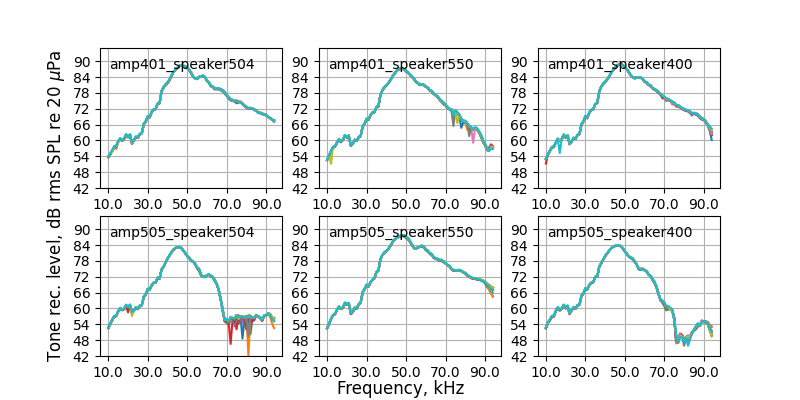

Text(0.1, -0.27, 'Frequency, kHz')

In [14]:
subset_inds = np.arange(0,freqs.size,20)

plt.figure(figsize=(8,4))
for i,combination in enumerate(combis):
    plt.subplot(231+i)
    plt.text(0.05,0.85,combination, transform=plt.gca().transAxes, fontsize=10)
    for each in multi_combi_tones[combination]:
        plt.plot(each['tone_freqs'],each['dbspl_rms'])
        plt.xticks(each['tone_freqs'][subset_inds], each['tone_freqs'][subset_inds]*0.001)
    plt.ylim(42,95);plt.yticks(np.arange(42,93,6));plt.grid()

plt.text(-0.30, -1.2, 'Tone rec. level, dB rms SPL re 20 $\mu$Pa', transform=plt.subplot(231).transAxes, rotation=90,
        fontsize=12)
plt.text(0.1, -0.27, 'Frequency, kHz', transform=plt.subplot(235).transAxes, fontsize=12)

<IPython.core.display.Javascript object>


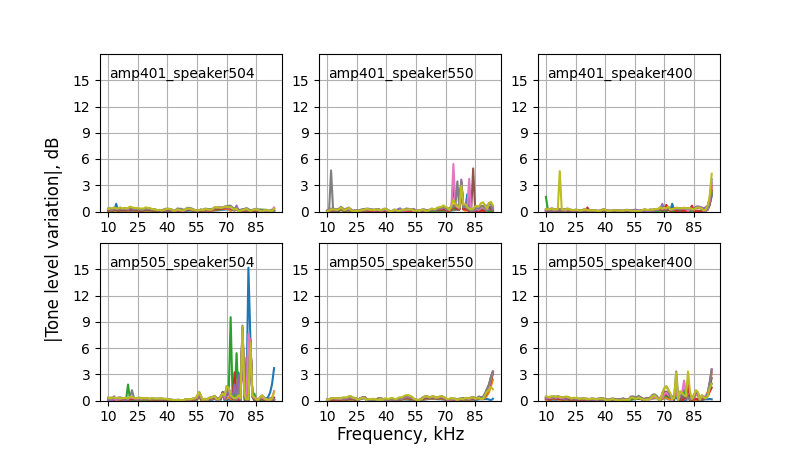

Text(0.1, -0.25, 'Frequency, kHz')

In [15]:
subset_inds = np.arange(0,freqs.size,15)
plt.figure(figsize=(8,4.5))
for i,combination in enumerate(combis):
    plt.subplot(231+i)
    plt.text(0.05,0.85,combination, transform=plt.gca().transAxes, fontsize=10)
    norm_1strec  = [multi_combi_tones[combination][0]['dbspl_rms']-each['dbspl_rms'] for each in multi_combi_tones[combination][1:]]
    for each in norm_1strec:
        plt.plot(freqs,np.abs(each))
        #plt.xticks(each['tone_freqs'][[0,10,50]], each['tone_freqs'][[0,10,50]]*0.001)
        plt.ylim(0,18);plt.yticks(np.arange(0,18,3));plt.grid();
        plt.xticks(freqs[subset_inds], np.int16(freqs[subset_inds]*0.001))


plt.text(-0.30, -.8, '|Tone level variation|, dB', transform=plt.subplot(231).transAxes, rotation=90,
        fontsize=12)
plt.text(0.1, -0.25, 'Frequency, kHz', transform=plt.subplot(235).transAxes, fontsize=12)

### Amp401-Speaker 504 produces the most tone playbacks also!

The combination (amp401-speaker504) I'd been using so far does actually produce a lot of variation for whatever reason!!

## Which speaker provides the most intense playback?

I fixed the relative orientation of the speaker w.r.t mic by hot-gluing some support rails on the tripod base. Did 3 measurements with each speaker using Amplifier401.  

In [16]:
may28_files = glob.glob('2021-05-28/*.wav')
may28_files

['2021-05-28\\gras-2mwall_amp401_speaker400_gaindB_50_azimuth_angle_0_2021-05-28_14-59-26.wav',
 '2021-05-28\\gras-2mwall_amp401_speaker504_gaindB_50_azimuth_angle_0_2021-05-28_14-55-42.wav',
 '2021-05-28\\gras-2mwall_amp401_speaker550_gaindB_50_azimuth_angle_0_2021-05-28_14-57-40.wav']

In [17]:
audio = [ sf.read(each)[0] for each in may28_files]
audio_bp = [ signal.lfilter(b,a,each) for each in audio]

<IPython.core.display.Javascript object>


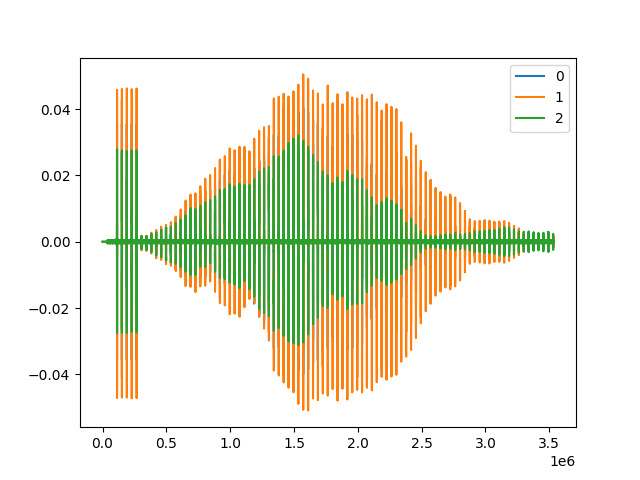

In [18]:
plt.figure()
for i, each in enumerate(audio_bp):
    plt.plot(each, label=i)
plt.legend()

The speakers clearly have very different source levels!! Let's just checkout what the difference is like.

In [19]:
20*np.log10([np.std(each) for each in audio_bp])

array([-57.39246545, -54.1360288 , -60.12357879])

### Speaker E504 is the loudest. 

In [20]:
print(f'This cell was run at: {dt.datetime.now()}')

This cell was run at: 2021-05-28 17:44:42.756175
